In [ ]:
from terratorch.registry import BACKBONE_REGISTRY
print(BACKBONE_REGISTRY.keys())

In [ ]:
model = BACKBONE_REGISTRY.build("prithvi_eo_v2_300")

In [ ]:
model.eval()

In [ ]:
import torch

# Create dummy input
dummy_input = torch.randn(2, 6, 224, 224)

# Forward pass
with torch.no_grad():
    output = model(dummy_input)

# Check output
print(f"Output type: {type(output)}")
print(f"Number of outputs: {len(output)}")
for i, out in enumerate(output):
    print(f"Output {i} shape: {out.shape}")

In [ ]:
# Get final layer output
final_output = output[-1]
print(f"Final output shape: {final_output.shape}")  # [2, 197, 1024]

# Extract CLS token (first token) for classification tasks
cls_token = final_output[:, 0, :]
print(f"CLS token shape: {cls_token.shape}")  # [2, 1024]

# Image Classification with Prithvi EO v2

This notebook demonstrates fine-tuning the Prithvi EO v2 model for satellite/aerial image classification on 45 classes.

In [ ]:
!pip install seaborn

## 1. Import Libraries and Setup

In [ ]:
!pip uninstall torch torchvision torchaudio -y

In [ ]:
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu118

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"GPU Name: {torch.cuda.get_device_name(0)}")


CUDA Available: True
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU


## 2. Dataset Preparation

In [3]:
class SatelliteImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Path to train/train or test/test folder
            transform: Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = sorted([d.name for d in self.root_dir.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Collect all image paths and labels
        self.samples = []
        for class_name in self.classes:
            class_dir = self.root_dir / class_name
            for img_path in class_dir.glob('*.jpg'):  # Adjust extension if needed
                self.samples.append((str(img_path), self.class_to_idx[class_name]))
        
        print(f"Found {len(self.samples)} images across {len(self.classes)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
# Define transforms - Prithvi expects 224x224 images with 6 channels (but we'll use 3 RGB channels)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = SatelliteImageDataset('Dataset/train/train', transform=train_transform)
test_dataset = SatelliteImageDataset('Dataset/test/test', transform=test_transform)

print(f"\nClasses: {train_dataset.classes[:5]}... (showing first 5 of {len(train_dataset.classes)})")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Found 27000 images across 45 classes
Found 4500 images across 45 classes

Classes: ['airplane', 'airport', 'baseball_diamond', 'basketball_court', 'beach']... (showing first 5 of 45)
Train samples: 27000
Test samples: 4500


In [5]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 844
Test batches: 141


## 3. Build Classification Model

In [6]:
class PrithviClassifier(nn.Module):
    def __init__(self, backbone, num_classes, feature_dim=1024, freeze_backbone=False):
        """
        Args:
            backbone: Pre-trained Prithvi model
            num_classes: Number of output classes
            feature_dim: Dimension of CLS token features (1024 for Prithvi)
            freeze_backbone: Whether to freeze backbone weights
        """
        super(PrithviClassifier, self).__init__()
        self.backbone = backbone
        
        # Freeze backbone if specified
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(feature_dim),
            nn.Dropout(0.3),
            nn.Linear(feature_dim, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        # Handle 3-channel RGB by repeating to 6 channels (Prithvi expects 6)
        if x.shape[1] == 3:
            x = torch.cat([x, x], dim=1)  # Duplicate RGB to make 6 channels
        
        # Extract features from backbone
        with torch.set_grad_enabled(not all(not p.requires_grad for p in self.backbone.parameters())):
            features = self.backbone(x)
        
        # Get CLS token from final layer output
        cls_token = features[-1][:, 0, :]  # [batch_size, 1024]
        
        # Classify
        logits = self.classifier(cls_token)
        
        return logits

In [7]:
# Load Prithvi backbone
from terratorch.registry import BACKBONE_REGISTRY

backbone = BACKBONE_REGISTRY.build("prithvi_eo_v2_300")
backbone.eval()

# Create classifier (start with frozen backbone for faster training)
num_classes = len(train_dataset.classes)
model = PrithviClassifier(backbone, num_classes=num_classes, freeze_backbone=True)
model = model.to(device)

print(f"Model created with {num_classes} classes")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

c:\Users\prana\Downloads\VIII-Sem-MP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model created with 45 classes
Trainable parameters: 549,933
Total parameters: 304,436,269


## 4. Training Setup

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

# Training configuration
num_epochs = 20  # Full training
max_batches_per_epoch = None  # Use all batches (set to a number to limit for testing)
best_accuracy = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [9]:
def train_epoch(model, dataloader, criterion, optimizer, device, max_batches=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    num_batches = max_batches if max_batches is not None else len(dataloader)
    
    with tqdm(total=num_batches, desc='🔥 Training', ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
        for batch_idx, (images, labels) in enumerate(dataloader):
            if max_batches is not None and batch_idx >= max_batches:
                break
                
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}', 
                'Acc': f'{100.*correct/total:.2f}%',
                'Samples': total
            })
            pbar.update(1)
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device, max_batches=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    num_batches = max_batches if max_batches is not None else len(dataloader)
    
    with torch.no_grad():
        with tqdm(total=num_batches, desc='✅ Validation', ncols=100, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:
            for batch_idx, (images, labels) in enumerate(dataloader):
                if max_batches is not None and batch_idx >= max_batches:
                    break
                    
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}', 
                    'Acc': f'{100.*correct/total:.2f}%',
                    'Samples': total
                })
                pbar.update(1)
    
    epoch_loss = running_loss / num_batches
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

## 5. Train the Model

In [10]:
print("Starting training...")
print(f"Device: {device}")
print(f"Epochs: {num_epochs}")
print(f"Batches per epoch: {max_batches_per_epoch}")
print(f"Batch size: {batch_size}")
print("-" * 50)

for epoch in range(num_epochs):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs}")
    print('='*60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, max_batches=max_batches_per_epoch)
    
    # Validate
    val_loss, val_acc = validate(model, test_loader, criterion, device, max_batches=max_batches_per_epoch)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Print epoch summary
    print(f"\n{'─'*60}")
    print(f"📊 EPOCH {epoch+1} SUMMARY:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print(f"{'─'*60}")
    
    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'accuracy': best_accuracy,
            'class_to_idx': train_dataset.class_to_idx
        }, 'best_prithvi_classifier.pth')
        print(f"✅ Saved best model (Val Acc: {best_accuracy:.2f}%)")

print("\n" + "=" * 60)
print(f"🎉 Training completed! Best validation accuracy: {best_accuracy:.2f}%")
print("=" * 60)

Starting training...
Device: cuda
Epochs: 20
Batches per epoch: None
Batch size: 32
--------------------------------------------------

EPOCH 1/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 1 SUMMARY:
  Train Loss: 3.0416 | Train Acc: 17.29%
  Val Loss:   2.6705 | Val Acc:   25.64%
  Learning Rate: 0.000994
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 25.64%)

EPOCH 2/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 2 SUMMARY:
  Train Loss: 2.8009 | Train Acc: 21.82%
  Val Loss:   2.5958 | Val Acc:   27.47%
  Learning Rate: 0.000976
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 27.47%)

EPOCH 3/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 3 SUMMARY:
  Train Loss: 2.7305 | Train Acc: 23.34%
  Val Loss:   2.4891 | Val Acc:   29.18%
  Learning Rate: 0.000946
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 29.18%)

EPOCH 4/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 4 SUMMARY:
  Train Loss: 2.6649 | Train Acc: 24.79%
  Val Loss:   2.4586 | Val Acc:   28.87%
  Learning Rate: 0.000905
────────────────────────────────────────────────────────────

EPOCH 5/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 5 SUMMARY:
  Train Loss: 2.6369 | Train Acc: 25.49%
  Val Loss:   2.4039 | Val Acc:   30.80%
  Learning Rate: 0.000854
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 30.80%)

EPOCH 6/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 6 SUMMARY:
  Train Loss: 2.5956 | Train Acc: 26.81%
  Val Loss:   2.3849 | Val Acc:   31.33%
  Learning Rate: 0.000794
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 31.33%)

EPOCH 7/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 7 SUMMARY:
  Train Loss: 2.5627 | Train Acc: 27.23%
  Val Loss:   2.3516 | Val Acc:   33.16%
  Learning Rate: 0.000727
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 33.16%)

EPOCH 8/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:18<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 8 SUMMARY:
  Train Loss: 2.5321 | Train Acc: 28.02%
  Val Loss:   2.3373 | Val Acc:   32.98%
  Learning Rate: 0.000655
────────────────────────────────────────────────────────────

EPOCH 9/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 9 SUMMARY:
  Train Loss: 2.5157 | Train Acc: 28.74%
  Val Loss:   2.3270 | Val Acc:   35.13%
  Learning Rate: 0.000579
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 35.13%)

EPOCH 10/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 10 SUMMARY:
  Train Loss: 2.4922 | Train Acc: 28.71%
  Val Loss:   2.3516 | Val Acc:   33.40%
  Learning Rate: 0.000501
────────────────────────────────────────────────────────────

EPOCH 11/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 11 SUMMARY:
  Train Loss: 2.4640 | Train Acc: 29.89%
  Val Loss:   2.2700 | Val Acc:   35.24%
  Learning Rate: 0.000422
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 35.24%)

EPOCH 12/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 12 SUMMARY:
  Train Loss: 2.4499 | Train Acc: 29.92%
  Val Loss:   2.2379 | Val Acc:   36.64%
  Learning Rate: 0.000346
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 36.64%)

EPOCH 13/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 13 SUMMARY:
  Train Loss: 2.4375 | Train Acc: 30.57%
  Val Loss:   2.2329 | Val Acc:   36.56%
  Learning Rate: 0.000274
────────────────────────────────────────────────────────────

EPOCH 14/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 14 SUMMARY:
  Train Loss: 2.4221 | Train Acc: 30.79%
  Val Loss:   2.2282 | Val Acc:   36.42%
  Learning Rate: 0.000207
────────────────────────────────────────────────────────────

EPOCH 15/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 15 SUMMARY:
  Train Loss: 2.4130 | Train Acc: 31.04%
  Val Loss:   2.2211 | Val Acc:   37.04%
  Learning Rate: 0.000147
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 37.04%)

EPOCH 16/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 16 SUMMARY:
  Train Loss: 2.3976 | Train Acc: 31.45%
  Val Loss:   2.2204 | Val Acc:   37.13%
  Learning Rate: 0.000096
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 37.13%)

EPOCH 17/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 17 SUMMARY:
  Train Loss: 2.3863 | Train Acc: 31.77%
  Val Loss:   2.2087 | Val Acc:   37.87%
  Learning Rate: 0.000055
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 37.87%)

EPOCH 18/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 18 SUMMARY:
  Train Loss: 2.3856 | Train Acc: 31.63%
  Val Loss:   2.1929 | Val Acc:   38.42%
  Learning Rate: 0.000025
────────────────────────────────────────────────────────────
✅ Saved best model (Val Acc: 38.42%)

EPOCH 19/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:16<00:00]



────────────────────────────────────────────────────────────
📊 EPOCH 19 SUMMARY:
  Train Loss: 2.3813 | Train Acc: 31.91%
  Val Loss:   2.1989 | Val Acc:   38.22%
  Learning Rate: 0.000007
────────────────────────────────────────────────────────────

EPOCH 20/20


✅ Validation: 100%|█████████████████████████████████████████████████████████| 141/141 [01:17<00:00]


────────────────────────────────────────────────────────────
📊 EPOCH 20 SUMMARY:
  Train Loss: 2.3779 | Train Acc: 32.03%
  Val Loss:   2.1956 | Val Acc:   38.20%
  Learning Rate: 0.000001
────────────────────────────────────────────────────────────

🎉 Training completed! Best validation accuracy: 38.42%


## 6. Visualize Training History

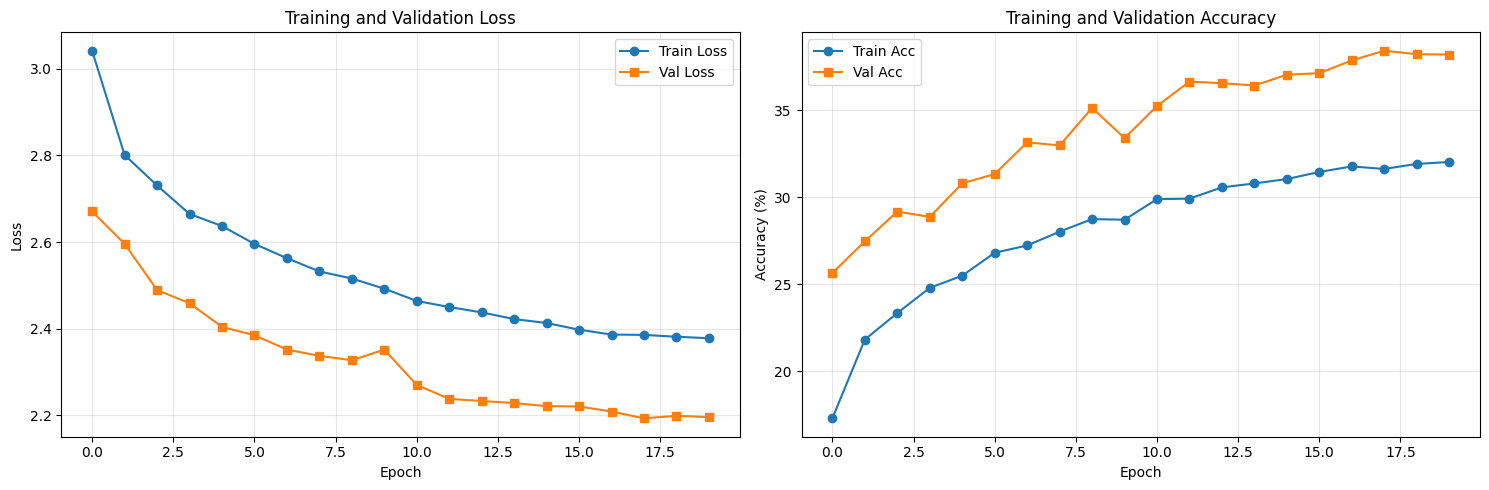

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Detailed Evaluation

In [12]:
# Load best model
checkpoint = torch.load('best_prithvi_classifier.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with accuracy {checkpoint['accuracy']:.2f}%")

# Get predictions for test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Evaluating'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

Loaded best model from epoch 18 with accuracy 38.42%


Evaluating: 100%|██████████| 141/141 [01:16<00:00,  1.84it/s]


In [13]:
# Classification report
print("\nClassification Report:")
print("=" * 80)
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Classification Report:
                       precision    recall  f1-score   support

             airplane       0.35      0.49      0.41       100
              airport       0.16      0.21      0.18       100
     baseball_diamond       0.24      0.30      0.27       100
     basketball_court       0.27      0.07      0.11       100
                beach       0.35      0.68      0.46       100
               bridge       0.39      0.22      0.28       100
            chaparral       0.75      0.72      0.73       100
               church       0.47      0.29      0.36       100
    circular_farmland       0.33      0.71      0.46       100
                cloud       0.55      0.63      0.59       100
      commercial_area       0.38      0.22      0.28       100
    dense_residential       0.46      0.68      0.55       100
               desert       0.72      0.87      0.79       100
               forest       0.62      0.82      0.70       100
              freeway       0.

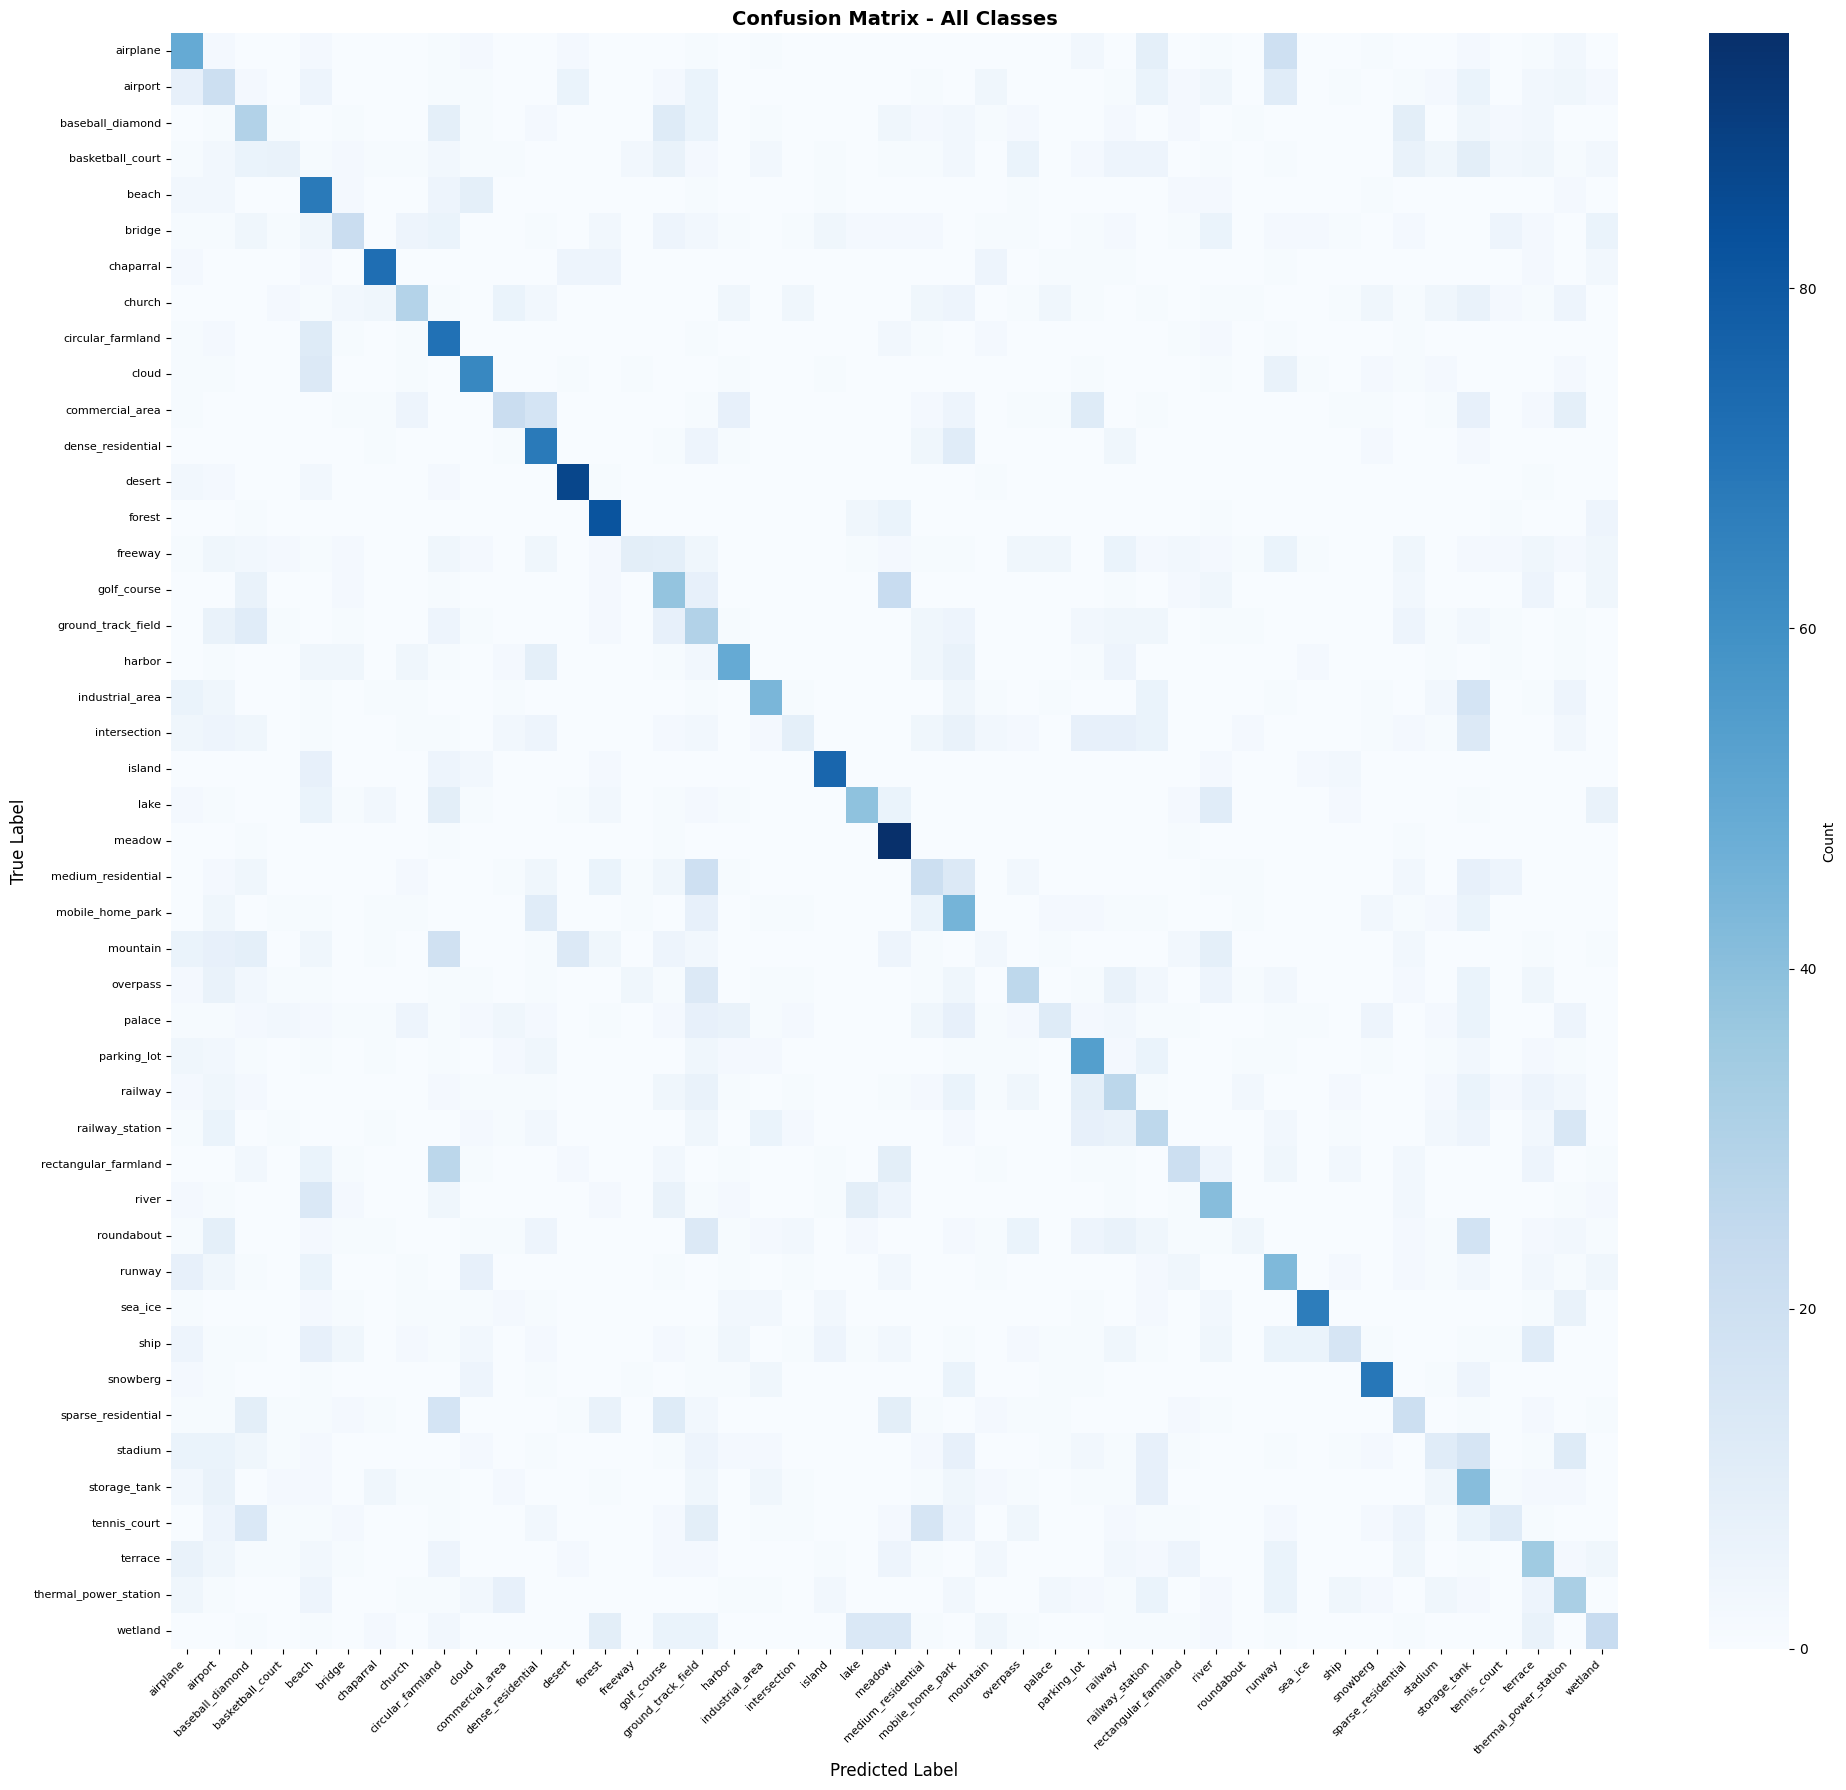

In [14]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - All Classes', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

## 8. Inference on Sample Images

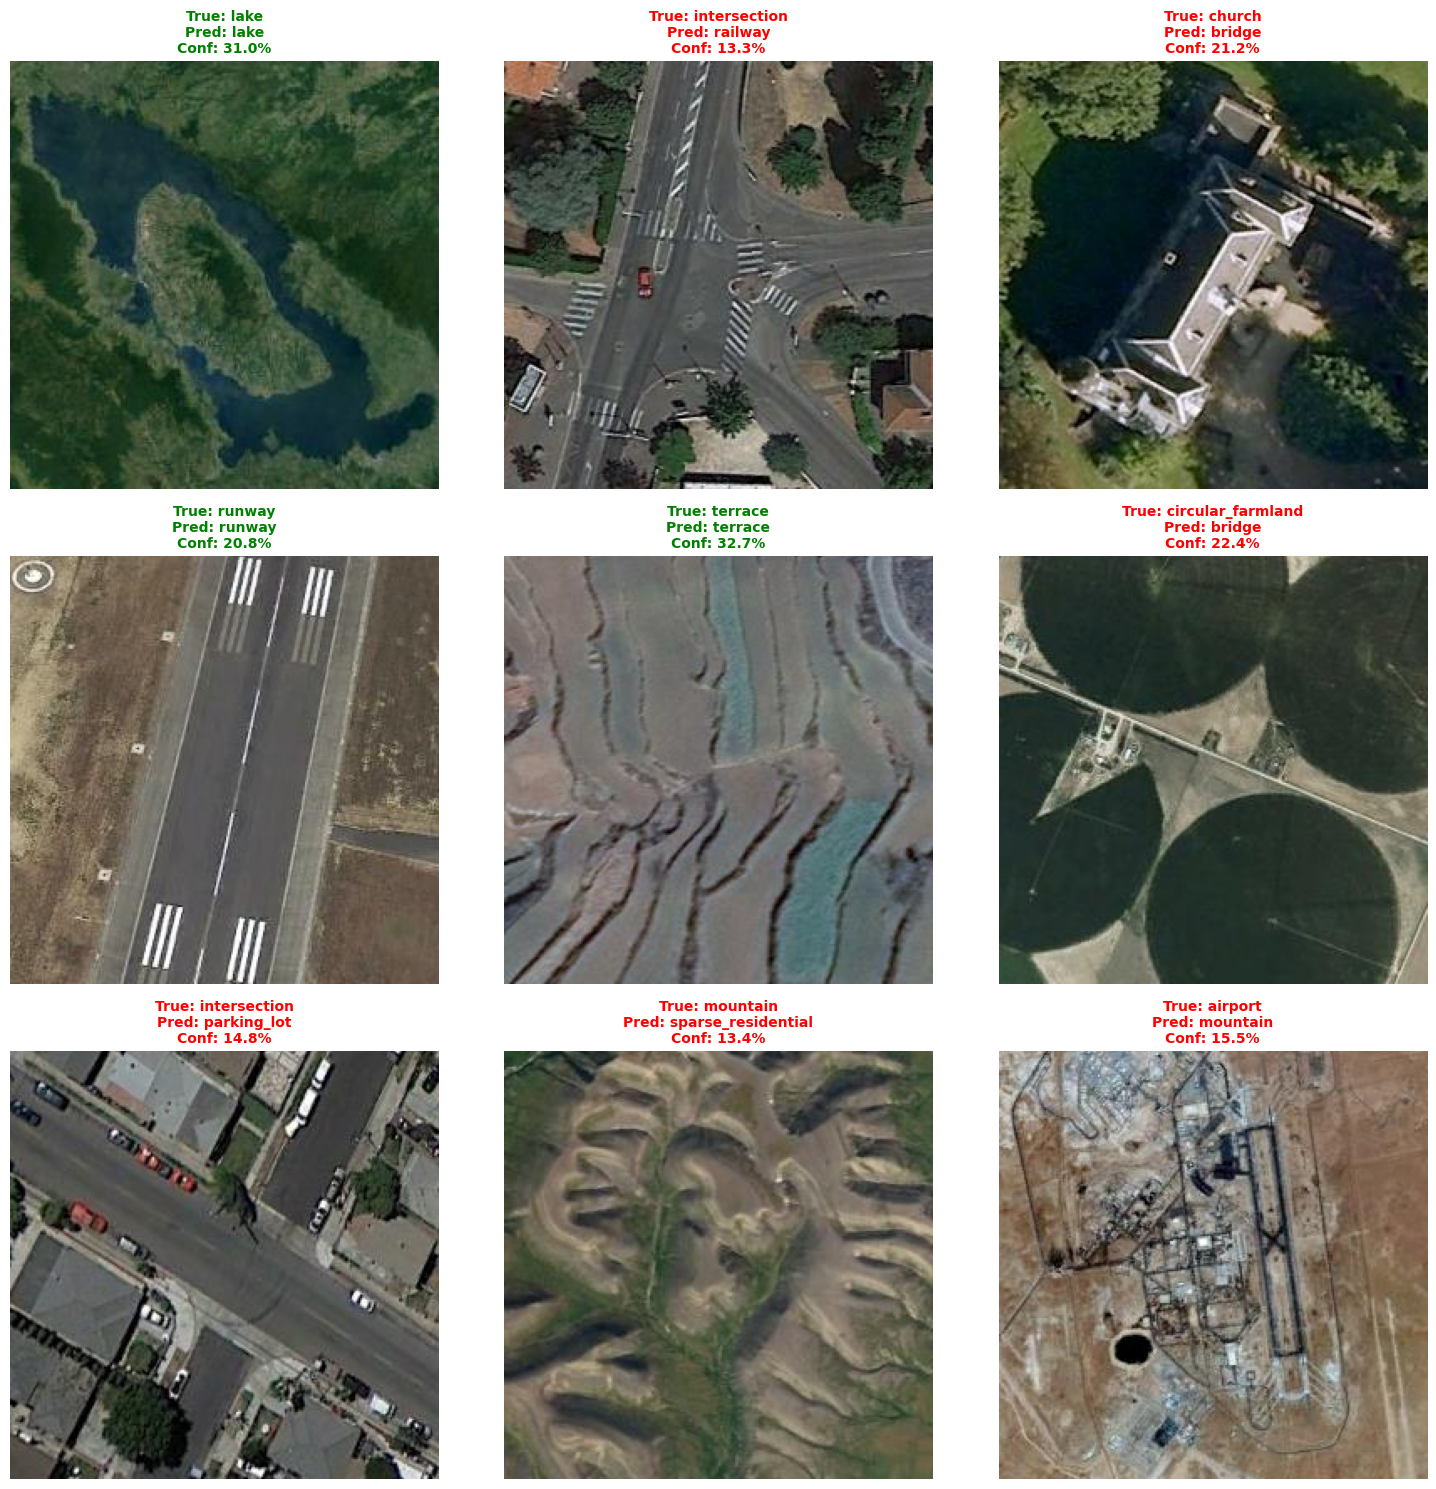

In [15]:
def predict_image(model, image_path, transform, class_names, device):
    """Predict class for a single image"""
    model.eval()
    
    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)[0]
        confidence, predicted_idx = torch.max(probabilities, 0)
    
    predicted_class = class_names[predicted_idx.item()]
    confidence_pct = confidence.item() * 100
    
    # Get top 5 predictions
    top5_prob, top5_idx = torch.topk(probabilities, 5)
    top5_classes = [(class_names[idx], prob.item() * 100) for idx, prob in zip(top5_idx, top5_prob)]
    
    return predicted_class, confidence_pct, top5_classes, image

def visualize_predictions(model, dataset, num_samples=9, device=device):
    """Visualize predictions on random test samples"""
    model.eval()
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.ravel()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx, ax in zip(indices, axes):
        img_path, true_label = dataset.samples[idx]
        
        predicted_class, confidence, top5, image = predict_image(
            model, img_path, dataset.transform, dataset.classes, device
        )
        
        true_class = dataset.classes[true_label]
        
        # Display image
        ax.imshow(image)
        ax.axis('off')
        
        # Color code: green for correct, red for incorrect
        color = 'green' if predicted_class == true_class else 'red'
        
        title = f"True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.1f}%"
        ax.set_title(title, fontsize=10, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions
visualize_predictions(model, test_dataset, num_samples=9)

## 9. Optional: Fine-tune the Backbone

If you want better results, you can unfreeze the backbone and fine-tune it with a lower learning rate.

In [16]:
# # Unfreeze backbone
# for param in model.backbone.parameters():
#     param.requires_grad = True

# # Use lower learning rate for fine-tuning
# optimizer_ft = optim.AdamW([
#     {'params': model.backbone.parameters(), 'lr': 1e-5},  # Lower LR for backbone
#     {'params': model.classifier.parameters(), 'lr': 1e-4}  # Higher LR for classifier
# ], weight_decay=0.01)

# scheduler_ft = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=10, eta_min=1e-7)

# print(f"Trainable parameters after unfreezing: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
# print("Ready for fine-tuning! Run the training loop again with optimizer_ft and scheduler_ft")